# Thompson Sampling Model

## Part 1

Imagine there are five slot machines. Each slot machine takes a dollar to play, and it either keeps your money or returns twice the amount. If you have $1000, how can you determine the best way to maximize your winnings?

One solution would be to play each machine 100 times, then determine the machine with the best odds. Once that is figured out, you could play on that machine for the rest of the time to maximize your winnings.

However, the problem is we want to find the best slot machine in <b>a minimum number of trials</b>.

This notebook will show how AI can be used to solve this "multi-armed bandit" problem.

![Nbandit](../references/N_armed_bandit_problem.png)

In [1]:
# import required libraries
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

# set the plotting inside the notebook
%matplotlib inline

In [2]:
# set the random seed for reproducing results
np.random.seed(0)

In [3]:
# how many times we can play
number_of_turns = 1_000

# how many slot machines there are
number_of_slot_machines = 5

# random conversion rates for each machine between 1% and 15%
conversion_rates = np.random.uniform(0.01, 0.15, number_of_slot_machines)

In [4]:
# initialize wins (positive rewards) and losses (negative rewards) for each machine
positive_rewards = np.zeros(number_of_slot_machines)
negative_rewards = np.zeros(number_of_slot_machines)

In [5]:
# initialize array of possible outcomes (turns x slot machines)
outcomes = np.zeros((number_of_turns, number_of_slot_machines))
for turn in range(number_of_turns): # for each turn
    for slot in range(number_of_slot_machines): # for each slot machine
        # create a random number (0,1) and compare to conversion
        # rate to determine if you won on this turn and this slot
        if np.random.rand() <= conversion_rates[slot]:
            outcomes[turn,slot] = 1

In [6]:
# show average win percentages
for i in range(number_of_slot_machines):
    print('Machine number {0} average win rate: {1:.2%}'.format(i + 1, np.mean(outcomes[:,i])))

Machine number 1 average win rate: 8.60%
Machine number 2 average win rate: 10.70%
Machine number 3 average win rate: 9.30%
Machine number 4 average win rate: 9.10%
Machine number 5 average win rate: 6.40%


In [7]:
# run Thompson sampling
for turn in range(number_of_turns): # for each turn
    best_slot = -1
    max_beta = -1
    
    # determine which slot machine to play this turn
    for slot in range(number_of_slot_machines): # for each slot machine
        # get beta shape parameters that depend on the number
        # of wins and losses observed thus far for each machine
        a = positive_rewards[slot] + 1
        b = negative_rewards[slot] + 1
        
        # get a random value from the beta distribution
        random_beta = np.random.beta(a, b)
        
        # get the largest beta value from the slot machines
        if random_beta > max_beta:
            max_beta = random_beta
            best_slot = slot
            
    # play the selected machine
    if outcomes[turn,best_slot] == 1:
        positive_rewards[best_slot] += 1
    else:
        negative_rewards[best_slot] += 1

In [8]:
# display the total number of selections for each machine
times_played = positive_rewards + negative_rewards
for i in range(number_of_slot_machines):
    print('Slot machine {0} was played {1} times.'.format(i + 1, times_played[i]))

Slot machine 1 was played 152.0 times.
Slot machine 2 was played 401.0 times.
Slot machine 3 was played 66.0 times.
Slot machine 4 was played 264.0 times.
Slot machine 5 was played 117.0 times.


In [9]:
# identify and display the best slot machine to play
print('The best slot machine to play is machine {}!'.format(np.argmax(times_played) + 1))

The best slot machine to play is machine 2!


In [10]:
# compare Thompson sampling to random sampling
thompson_sampling_wins = np.sum(positive_rewards)

# determine how many wins we would get by random sampling
random_sampling_wins = 0
for turn in range(number_of_turns): # each turn
    selected_machine = np.random.randint(0, number_of_slot_machines) # random selection
    if outcomes[turn,selected_machine] == 1:
        random_sampling_wins += 1

In [11]:
# display comparison
print('Total wins with Thompson sampling: {0:.0f}'.format(thompson_sampling_wins))
print('Total wins with Random sampling: {0:.0f}'.format(random_sampling_wins))

Total wins with Thompson sampling: 96
Total wins with Random sampling: 79


Slot machine 1 conversion rate = 8.68%
Slot machine 2 conversion rate = 11.01%
Slot machine 3 conversion rate = 9.44%
Slot machine 4 conversion rate = 8.63%
Slot machine 5 conversion rate = 6.93%


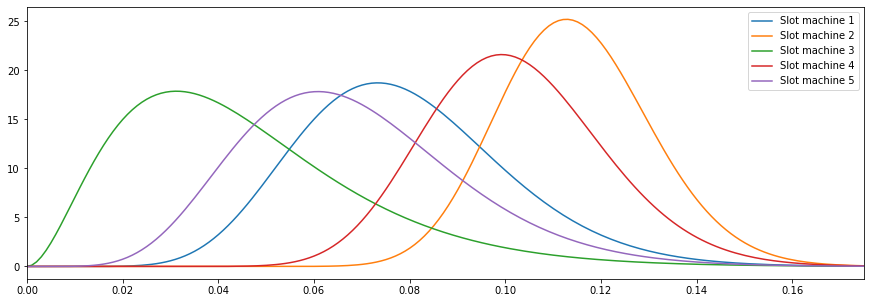

In [12]:
# compare beta estimations with actual rates
fig, ax = plt.subplots(figsize=(15,5))

x = np.linspace(0, 1, 1_000)
count = 0
for a, b in zip(positive_rewards, negative_rewards):
    label = 'Slot machine {}'.format(count + 1)
    print('Slot machine {0} conversion rate = {1:.2%}'.format(count + 1, conversion_rates[count]))
    plt.plot(x, beta.pdf(x, a, b), label=label)
    count += 1

plt.xlim(0,0.175);
plt.legend();

## Part 2

Imagine an e-commerce business that has millions of customers. These customers are people buying products on the website from time to time, getting those products delivered to their homes. The business is doing well, but the board of executives has decided to follow an action plan to maximize revenue.

This plan consists of offering the customers the option to subscribe to a premium plan, which will give them benefits like reduced prices, special deals, and so on. This premium plan is offered at a yearly price of $200, and the goal of this e-commerce business is, of course, to get the maximum number of customers to subscribe to this premium plan.

Given multiple stategies (9) with unknown conversion rates let's use thompson sampling AI methods to determine the best strategy to maximize the number of subscribers. The strategies are shown below, and we will assume they have constant rates that we do not know.

![strategies](../references/strategies.png)

As a customer navigates the website, they will suddenly get a pop-up ad, suggesting to them that they subscribe to the premium plan. Only one of the nine strategies will be displayed. Then the user will choose, or not, to take action and subscribe to the premium plan. If the customer subscribes, the strategy is a success; otherwise, it is a failure. The more customers we do this with, the more feedback we collect, and the better idea we get of what the best strategy is.

In [13]:
# define an advertising class to hold details for each strategy
class Advertisement:
    # initialize the strategy
    def __init__(self, strategy):
        self.id = strategy
        # assign a random conversion rate between 1% and 20%
        self.conversion_rate = np.random.uniform(0.01, 0.20)
        # assign a amount of profit per successful sale
        self.profit_per_sale = 200
        # track number of wins and losses
        self.sales = 0
        self.no_sales = 0
        
    # the total number of trials for this strategy
    def total_trials(self):
        return self.sales + self.no_sales
    
    # the total profit generated thus far
    def total_profit(self):
        return self.sales * self.profit_per_sale
    
    # the actual amount of profit per trial
    def profit_per_trial(self):
        if self.total_trials() > 0:
            return self.total_profit() / self.total_trials()
        else:
            return 0.
    
    # the expected (theoretical) earnings per trial
    def expected_profit_per_trial(self):
        return self.conversion_rate * self.profit_per_sale

In [14]:
# a function to test an advertising strategy
def try_advertisement(strategy):
    if np.random.random() <= strategy.conversion_rate:
        strategy.sales += 1
    else:
        strategy.no_sales += 1

In [15]:
# define number of advertising campaigns
number_of_advertisements = 9

# define number of customers (trials)
number_of_customers = 1_000_000

# list to hold advertisements
campaigns = []

In [16]:
# initialize advertisement strategies
for c in range(number_of_advertisements):
    campaigns.append(Advertisement(c))

In [17]:
# simulate Thompson sampling
for customer in range(number_of_customers): # for each customer
    best_ad = -1
    max_beta = -1
    
    # determine which advertisement to try this turn
    for ad in campaigns: # for each advertisement
        # get beta shape parameters that depend on the number
        # of wins and losses observed thus far for each advertisement
        a = ad.sales + 1
        b = ad.no_sales + 1
        
        # get a random value from the beta distribution
        random_beta = np.random.beta(a, b)
        
        # get the largest beta value from the strategies
        if random_beta > max_beta:
            max_beta = random_beta
            best_ad = ad.id
            
    # try the chosen advertisement on the current customer
    try_advertisement(campaigns[best_ad])

In [18]:
# compare thompson sampling against uniform sampling
thompson_sampling_profit = 0
uniform_sampling_profit = 0

# number of customers for each advertising campaign
customers_per_ad = number_of_customers // number_of_advertisements

for ad in campaigns:
    print('Advertisement {0}: profit per trial = {1:.4}, total trials = {2}'.format(ad.id + 1, ad.profit_per_trial(), ad.total_trials()))
    thompson_sampling_profit += ad.total_profit()
    uniform_sampling_profit += (customers_per_ad * ad.conversion_rate * ad.profit_per_sale)

# print overall results
print('\nThompson sampling total profit: {0}'.format(thompson_sampling_profit))
print('Uniform sampling total profit: {0}'.format(round(uniform_sampling_profit)))

absolute_improvement = round(thompson_sampling_profit - uniform_sampling_profit)
print('\nAbsolute improvement: {0}'.format(absolute_improvement))
print('Relative improvement: {0:.2%}'.format((absolute_improvement / uniform_sampling_profit)))

Advertisement 1: profit per trial = 29.77, total trials = 1075
Advertisement 2: profit per trial = 12.03, total trials = 133
Advertisement 3: profit per trial = 22.16, total trials = 361
Advertisement 4: profit per trial = 33.77, total trials = 4773
Advertisement 5: profit per trial = 31.14, total trials = 1413
Advertisement 6: profit per trial = 19.77, total trials = 263
Advertisement 7: profit per trial = 4.878, total trials = 82
Advertisement 8: profit per trial = 38.69, total trials = 991758
Advertisement 9: profit per trial = 12.68, total trials = 142

Thompson sampling total profit: 38627400
Uniform sampling total profit: 21950798

Absolute improvement: 16676602
Relative improvement: 75.97%


In [19]:
# compare conclusions with actual conversion rates
selections = []
for ad in campaigns:
    print('Advertisement {0}: conversion rate = {1:.2%}'.format(ad.id + 1, ad.conversion_rate))
    selections.append(ad.total_trials())
    
print('\nBest advertisement strategy is {0}!'.format(selections.index(max(selections)) + 1))

Advertisement 1: conversion rate = 15.11%
Advertisement 2: conversion rate = 2.92%
Advertisement 3: conversion rate = 11.81%
Advertisement 4: conversion rate = 17.83%
Advertisement 5: conversion rate = 14.99%
Advertisement 6: conversion rate = 9.53%
Advertisement 7: conversion rate = 2.99%
Advertisement 8: conversion rate = 19.37%
Advertisement 9: conversion rate = 4.24%

Best advertisement strategy is 8!


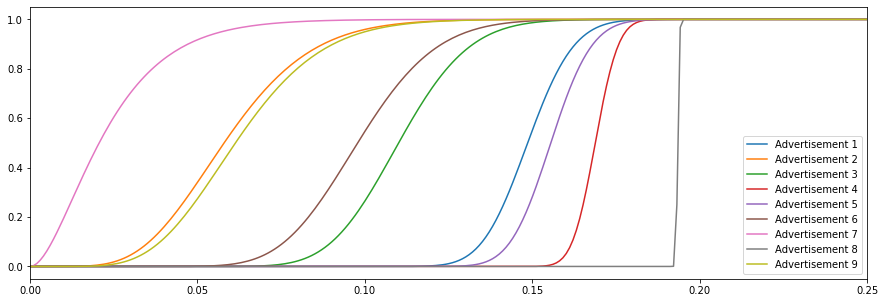

In [20]:
# compare beta estimations with actual rates
fig, ax = plt.subplots(figsize=(15,5))

x = np.linspace(0, 1, 1000)
for ad in campaigns:
    label = 'Advertisement {}'.format(ad.id + 1)
    a, b = ad.sales, ad.no_sales
    distribution = beta(a, b)
    plt.plot(x, distribution.cdf(x), label=label)

plt.xlim(0,0.25);
plt.legend();